Сегментация изображения методом спектральной кластеризации
Описание задачи
Цель: разделить изображение монет на несколько регионов, используя спектральную кластеризацию .

Алгоритм:

Изображение преобразуется в граф
Каждый пиксель — вершина графа
Рёбра между соседними пикселями строятся на основе разницы яркости
Применяется спектральная кластеризация для выделения регионов
Источник данных:

Встроенное изображение coins() из библиотеки skimage

1. Импорт библиотек

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.data import coins
from skimage.transform import rescale

from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image

2. Загрузка и подготовка изображения

In [2]:
# Загружаем изображение монет
orig_coins = coins()

# Уменьшаем размер изображения для ускорения обработки
# Перед уменьшением применяем фильтр Гаусса, чтобы уменьшить артефакты
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect", anti_aliasing=False)

print("Форма исходного изображения:", orig_coins.shape)
print("Форма после масштабирования:", rescaled_coins.shape)

Форма исходного изображения: (303, 384)
Форма после масштабирования: (61, 77)


3. Построение графа

In [3]:
# Преобразуем изображение в граф
graph = image.img_to_graph(rescaled_coins)

# Уменьшаем веса рёбер экспоненциальной функцией
beta = 10
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

print("Граф построен")

Граф построен


4. Спектральная кластеризация

Спектральная кластеризация: kmeans, 2.62с
Спектральная кластеризация: discretize, 0.89с
Спектральная кластеризация: cluster_qr, 2.17с


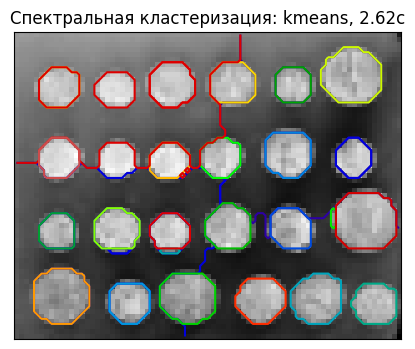

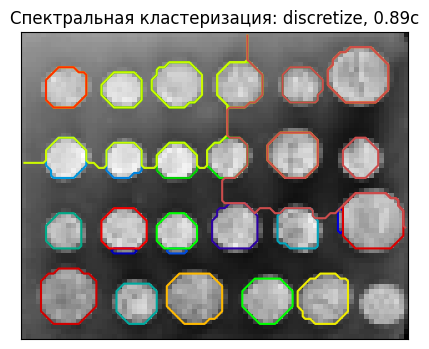

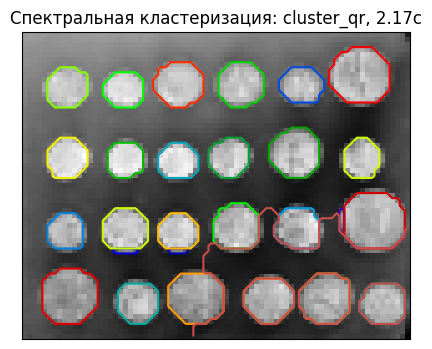

In [4]:
# Количество регионов
n_regions = 26
n_plus = 3  # дополнительные кластеры для лучшей сегментации

# Выполняем кластеризацию тремя способами
for assign_labels in ("kmeans", "discretize", "cluster_qr"):
    t0 = time.time()
    
    labels = spectral_clustering(
        graph,
        n_clusters=(n_regions + n_plus),
        eigen_tol=1e-7,
        assign_labels=assign_labels,
        random_state=42,
    )

    t1 = time.time()
    labels = labels.reshape(rescaled_coins.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_coins, cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

    title = f"Спектральная кластеризация: {assign_labels}, {t1 - t0:.2f}с"
    print(title)
    plt.title(title)

    for l in range(n_regions):
        colors = [plt.cm.nipy_spectral((l + 4) / float(n_regions + 4))]
        plt.contour(labels == l, colors=colors)

plt.show()

5. Интерпретация результатов

Каждое изображение показывает контуры найденных регионов. Цвета используются только для наглядности и не имеют семантической нагрузки.

    Методы:

'kmeans' — стабильный, но может быть медленным
'discretize' — итеративный метод, работает быстрее
'cluster_qr' — новый экспериментальный метод, основанный на QR-разложении